# INF-616 - Tarefa 3 - *OvO*/*OvR* e teste de hipótese nula

Professor: Jacques Wainer -- wainer@ic.unicamp.br  
Monitor: Lucas David -- ra188972@students.ic.unicamp.br

Instituto de Computação - Unicamp  
2018 

Alunos: Liselene Borges e Marcos Scarpim 


In [1]:
from __future__ import print_function

import itertools
import warnings
from time import time

import numpy as np
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline

np.random.seed(42)

In [2]:
digits = datasets.load_digits()
x, y = digits.data, digits.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5)

# de amostras de treino: 898
# de amostras de teste: 899
# de características: 64
# de classes: 10

Algumas amostras de dígitos:


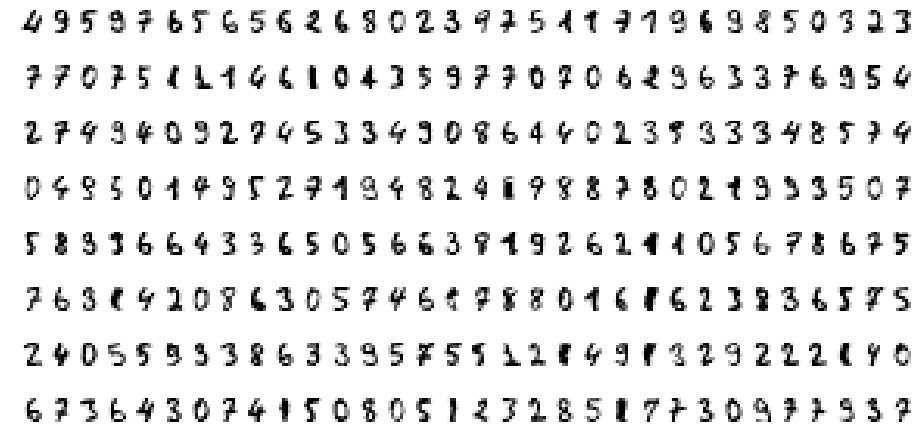

In [3]:
print('# de amostras de treino: %i' % x_train.shape[0],
      '# de amostras de teste: %i' % x_test.shape[0],
      '# de características: %s' % x_train.shape[1],
      '# de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

print('Algumas amostras de dígitos:')
_ = plt.figure(figsize=(16, 8))
for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

In [4]:
# Abaixo estão algumas funções que podem ser úteis no decorrer dessa atividade:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Originally implemented at: <http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html>
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('classe verdadeira')
    plt.xlabel('class predita')


def train_and_evaluate(tag, model, train, test):
    """Treina um modelo `model` sobre o conjunto `train=(x, y)` e avalia
       os resultados sobre o conjunto `test`.
    """
    (x_train, y_train), (x_test, y_test) = train, test
    p_test = model.fit(x_train, y_train).predict(x_test)

    print('~> Strategy', tag)
    print(metrics.classification_report(y_test, p_test, target_names=digits.target_names.astype(str)))

    plot_confusion_matrix(metrics.confusion_matrix(test[1], p_test),
                          digits.target_names.astype(str),
                          title='Matriz de confusão sobre Digits/teste c/ a estratégia %s' % tag)

### OvO e OvR

**Por padrão, os classificadores do sklearn assumem a estratégia one-vs-one. Utilize a função `train_and_evaluate` acima, passando um SVC linear convencional usando os hiperparametros default (nesse caso C=1), estudado até agora, e observe a pontuação sobre o conjunto de teste.**


~> Strategy Linear
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        82
          1       0.97      0.99      0.98        89
          2       1.00      1.00      1.00        83
          3       0.99      0.95      0.97        93
          4       0.97      0.99      0.98        93
          5       0.99      0.97      0.98        99
          6       1.00      0.98      0.99        98
          7       0.97      0.99      0.98        87
          8       0.94      0.93      0.93        83
          9       0.97      0.98      0.97        92

avg / total       0.98      0.98      0.98       899



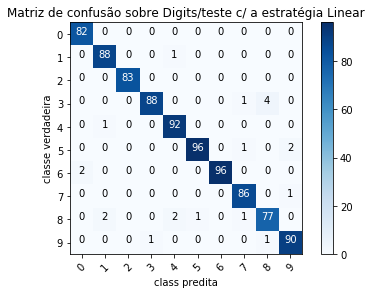

In [5]:
# train and evaluate a "conventional" model...
from sklearn.svm import SVC
SVC_GAMMA        = 0.001
SVC_RANDOM_STATE = 13
model = SVC(C=1, kernel="linear")
train = (x_train, y_train)
test = (x_test, y_test)
train_and_evaluate("Linear",model, train, test)

**Para se adotar uma estratégia diferente, é necessário a utilização de algum dos *wrappers* em `sklearn.multiclass`. Utilize as classes adequadas para corretamente executar as abordagens OvO e OvR. Treine e avalie os resultados sobre *digits*.**

Garanta que ambos os classificadores começem com o mesmo estado aleatório `rs`

In [ ]:
rs = 571

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


ovo_model = OneVsOneClassifier(SVC(kernel='linear', random_state=rs))
ovr_model = OneVsRestClassifier(SVC(kernel='linear', random_state=rs))

# Treinar e avaliar ambos modelos...

Os resultados obtidos na célula acima são suficientes para afirmar que algum dos
classificadores (OvO e OvR) é *provavelmente* melhor que o outro sobre o conjunto
*digits*?

Agora vamos rodar `OvO` vs `OvA`, mas usando 5 repedições de 2 *folds*.

In [ ]:
from sklearn.model_selection import cross_validate, RepeatedKFold


cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=41)

ovo_model = OneVsOneClassifier(SVC(kernel='linear', random_state=rs))
ovo=cross_validate(ovo_model,x,y,cv=cv)

# ovr = ...

Qual é a melhor estrategia? Use a mediana dos `test_score` do dicionário resultante:

In [ ]:
# print(...)

Verifique se a diferença do `test_score` entre `OvO` e `OvR` é estatisticamente signifidante:

In [ ]:
from scipy import stats

# Testar e reportar p-valor...

### Comparação estatística entre GBMs OvO e OvR

**Sejam `ovo_model` e `ovr_model` modelos `GBM` (ou `GradientBoostingClassifier`) que se apoiam sobre as estratégias OvO e OvR, respectivamente. Utilize 5x2 CV a fim de otimizar os hiper-parâmetros e construir duas distribuições de pontuações sobre as folds de validação formadas, respeitando as seguintes restrições:**

- Busque na grade de hiper-parâmetros do estimador pela combinação que maximiza a pontuação f1-macro média sobre as folds de validação.
- Garanta que ao menos os parâmetros *número de árvores* e *profundidade dos ramos* pertencam à sua grade de busca.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

params = dict(estimator__n_estimators=[10, 20, 30],
              estimator__max_depth=[2, 3, 5])
gbc = GradientBoostingClassifier(random_state=rs)

In [ ]:
ovo_model=GridSearchCV(OneVsOneClassifier(gbc),params,cv=3)

In [ ]:
cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=41)

# Vai demorar vários minutos para rodar a linha abaixo:
ovo = cross_validate(ovo_model,x,y,cv=cv)
ovo

In [ ]:
# Avaliar OvR...

Qual o melhor?

In [ ]:
# print('OvO:', ...)
# print('OvR:', ...)